In [71]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
 
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D,Conv2D
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, TimeDistributed, MaxPooling2D
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from keras.utils import to_categorical, normalize

import psycopg2
from configparser import ConfigParser
plt.style.use('fivethirtyeight')

pd.options.display.max_columns = 50  # None -> No Restrictions
pd.options.display.max_rows = 200    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

print ('import completed')

import completed


In [83]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
#timesteps per samples
Enrol_window = 20

print ('enrol window set to',Enrol_window )

enrol window set to 20


In [119]:
# Support functions
scaler = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
std_scaler = StandardScaler()


# for multivariate, nth timesteps output is used for n timesteps input so first output before nth is not used (Multiple Input Series)
def split_multi(sequences, n_steps):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix, -1])
        
    return np.array(X), np.array(y)

def split_multi_output(sequences, n_steps_in, n_steps_out):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix:out_end_ix, -1])
        
    return np.array(X), np.array(y)
                           
#for univariate(1 feature)
def split_uni(sequences, n_steps,normalise_window):
    sequence_length = n_steps + 1
    result = []
    for index in range(len(sequences) - sequence_length):
        result.append(sequences[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    return np.array(result)
                           
def load_data(datasetname, column, seq_len, normalise_window, n_outputs):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]
    
    row = round(0.8 * data.shape[0])
    
    if normalise_window:
        data = std_scaler.fit_transform(data)
        data = scaler.fit_transform(data)
    
    data = pd.DataFrame(data,columns = column)
    
    data_train = data[:int(row)]
    data_test = data[int(row):]
    
#     if normalise_window:
#         data_train = std_scaler.fit_transform(data_train)
#         data_test = std_scaler.transform(data_test)
        
#         data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
#           data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
# scaler_y = MinMaxScaler(feature_range=(0,1))
        
    
#     data = pd.DataFrame(data,columns = column)
#     data_test = pd.DataFrame(data_test,columns = data.columns)
    
    print(data.describe())
    
    x_train, y_train = split_multi_output(data_train, seq_len, n_outputs)
    x_test, y_test = split_multi_output(data_test, seq_len, n_outputs)
    
#     y_train =to_categorical(y_train)
#     y_test =to_categorical(y_test)
    print(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white', figsize = (12,12)) 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(predicted_data, label='Prediction', color ='red') 
    plt.legend() 
    plt.show() 

def plot_result(predicted_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


In [5]:
lq45 = ['ACES','ADRO','AKRA','ANTM','ASII',
            'BBCA','BBNI','BBRI','BBTN','BMRI',
            'BSDE','BTPS','CPIN','CTRA','ERAA',
            'EXCL','GGRM','HMSP','ICBP','INCO',
            'INDF','INKP','INTP','ITMG','JPFA',
            'JSMR','KLBF','MDKA','MIKA','MNCN',
            'PGAS','PTBA','PTPP','PWON','SCMA',
            'SMGR','SMRA','SRIL','TBIG','TKIM',
            'TLKM','TOWR','UNTR','UNVR','WIKA'
       ]

kompas100 = 'AALI,ACES,ADHI,ADRO,AKRA,ANTM,APLN,ASII,ASSA,BBCA,BBKP,BBNI,BBRI,BBTN,BDMN,BEST,BJBR,BJTM,BMRI,BMTR,BNLI,BRIS,BRPT,BSDE,BTPS,BULL,CLEO,CPIN,CTRA,DMAS,ELSA,ERAA,EXCL,GGRM,GIAA,HKMU,HMSP,HOKI,ICBP,INAF,INCO,INDF,INDY,INKP,INTP,ISAT,ITMG,JPFA,JRPT,JSMR,KAEF,KBLI,KINO,KLBF,LINK,LPKR,LPPF,LSIP,MAIN,MAPI,MDKA,MEDC,MIKA,MNCN,MTDL,MYOR,PGAS,PNBN,PNLF,PSAB,PTBA,PTPP,PWON,RALS,SCMA,SIDO,SILO,SIMP,SMBR,SMGR,SMRA,SMSM,SPTO,SRIL,SSIA,SSMS,TBIG,TINS,TKIM,TLKM,TOWR,TPIA,UNTR,UNVR,WEGE,WIKA,WOOD,WSBP,WSKT,WTON'
kompas100 = kompas100.split(',')

def config(filename="D:\python\database.ini", section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

def get_stocks_data(date):
    """ query tickers from the idxstocks table """
    conn = None
    stocks_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        sql="SELECT * FROM idxstocks WHERE date >= %s::Date"
        stocks_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(stocks_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return stocks_df

def get_broksum_data(date):
    conn = None
    broksum_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        sql="SELECT * FROM brokersummary WHERE date >= %s::Date"
        broksum_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(broksum_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return broksum_df

all_stocks_df = get_stocks_data("2014-01-01")
all_stocks_df['date'] = pd.to_datetime(all_stocks_df['date'])
all_stocks_df =all_stocks_df.set_index('date').sort_index()
# broksum_df = get_broksum_data("2018-01-01")


The number of dates:  854595


In [6]:
display(all_stocks_df)
# display(broksum_df)


,stock,stock_name,remarks,prev,open_price,first_trade,high,low,close,change,volume,value,freq,index_individual,offer,offer_volume,bid,bid_volume,listed_shares,tradable_shares,weight_for_index,foreign_sell,foreign_buy,non_regular_volume,non_regular_value,non_regular_freq
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,CKRA,Cakra Mineral Tbk.,--U2---2,199,0,0,0,0,199,0,0,0,0,88.6,207,200,199,50000,5106021090,5106021090,5106021090,0,0,0,0,0
2015-01-02,DUTI,Duta Pertiwi Tbk,--U6---2,4880,0,0,0,0,4880,0,0,0,0,490.8,4900,4800,4300,1000,1850000000,1850000000,1850000000,0,0,0,0,0
2015-01-02,DVLA,Darya-Varia Laboratoria Tbk.,--U5---1,1690,0,0,1600,1600,1600,-90,1400,2240000,2,588.9,1620,400,1560,1000,1120000000,1120000000,1120000000,0,0,0,0,0
2015-01-02,DYAN,Dyandra Media International Tbk.,--U9---1,138,0,0,138,136,138,0,451600,62198600,31,39.4,138,800,137,1100,4272964279,4255764279,4272964279,0,0,0,0,0
2015-01-02,ECII,Electronic City Indonesia Tbk.,--U9---2,1090,0,0,1050,1020,1050,-40,1700,1769500,5,25.9,1050,600,1045,1100,1334333000,1334333000,1334333000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,FISH,FKS Multi Agro Tbk.,--U-213500000091--------------,2620,0,0,2620,2620,2620,0,100,262000,1,2096.0,2840,100,2630,1000,480000000,480000000,480000000,0,0,0,0,0
2020-12-23,FITT,Hotel Fitra International Tbk.,--U-213000000094--------------,73,0,0,83,73,74,1,629800,49672100,73,72.5,75,100,74,5400,600000005,376000005,600000005,0,0,0,0,0
2020-12-23,FMII,Fortune Mate Indonesia Tbk,--U-213500000061--------------,670,0,0,0,0,670,0,0,0,0,670.0,630,100,625,1200,2721000000,2721000000,2721000000,0,0,0,0,0


C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,prev,high,low,close,volume,value,freq,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,nbsa,nbsa_cumsum,fn_vol,fn_part,fn_net_str,log_ret_close,label
date,,,,,,,,,,,,,,,,,,,,
2015-01-02,13125,13275,13150,13225,15.584,25.073,7.742,4,1,1,2,2,1,282300,504208200,15.405,0.836,0.029,0.000,13225
2015-01-05,13225,13200,13125,13200,15.442,24.928,7.541,0,1,1,5,5,2,73900,504282100,15.305,0.872,0.008,-0.002,13200
2015-01-06,13200,13200,13000,13100,16.091,25.572,8.032,1,1,1,6,6,2,-187600,504094500,15.891,0.818,0.012,-0.008,13100
2015-01-07,13100,13200,13050,13125,15.903,25.387,7.731,2,1,1,7,7,2,337500,504432000,15.803,0.905,0.023,0.002,13125
2015-01-08,13125,13150,12975,12975,16.203,25.680,8.272,3,1,1,8,8,2,-3207600,501224400,15.671,0.587,0.251,-0.011,12975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-17,34750,35000,34100,34675,16.727,27.180,9.720,3,4,12,352,17,51,2488700,188961400,16.408,0.727,0.093,-0.002,34675
2020-12-18,34675,34675,33775,34000,17.198,27.636,9.752,4,4,12,353,18,51,1052300,190013700,16.841,0.700,0.026,-0.020,34000
2020-12-21,34000,34450,34000,34150,16.746,27.187,9.386,0,4,12,356,21,52,9626800,199640500,16.207,0.583,0.440,0.004,34150


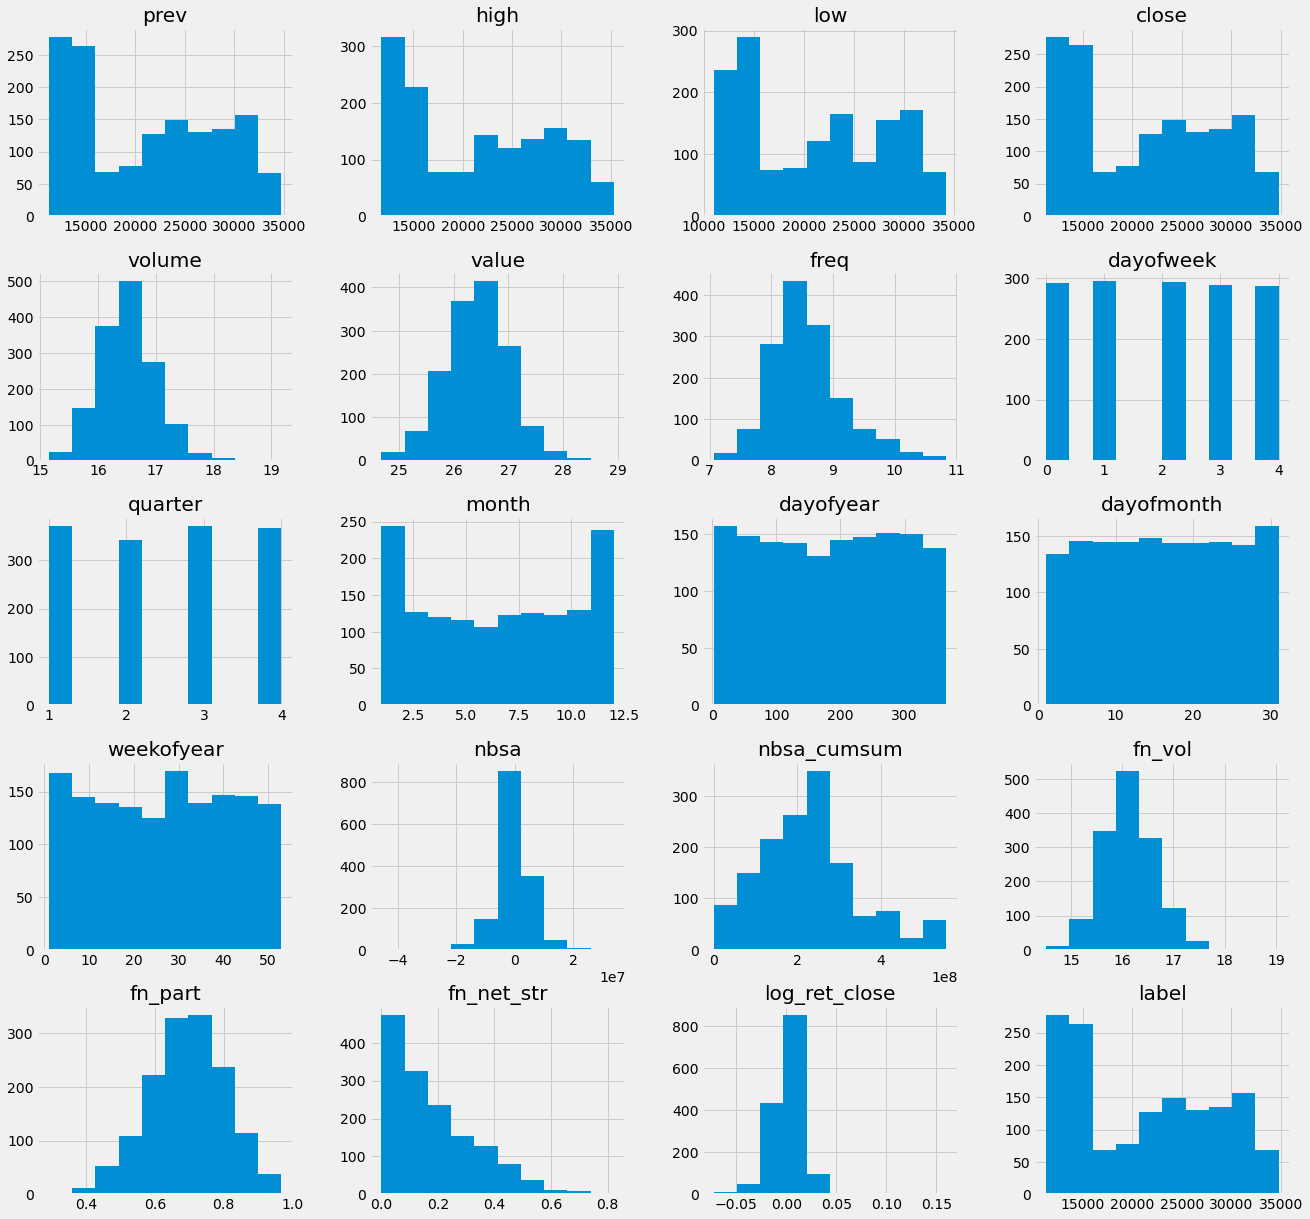

In [130]:
selected_stocks = ['BBCA']
stock_df_selected = all_stocks_df[all_stocks_df.stock.isin(selected_stocks)]
stock_df_selected['date'] = stock_df_selected.index
stock_df_selected['dayofweek'] = stock_df_selected['date'].dt.dayofweek
stock_df_selected['quarter'] = stock_df_selected['date'].dt.quarter
stock_df_selected['month'] = stock_df_selected['date'].dt.month
# stock_df_selected['year'] = stock_df_selected['date'].dt.year
stock_df_selected['dayofyear'] = stock_df_selected['date'].dt.dayofyear
stock_df_selected['dayofmonth'] = stock_df_selected['date'].dt.day
stock_df_selected['weekofyear'] = stock_df_selected['date'].dt.weekofyear


stock_df_selected['nbsa'] = stock_df_selected['foreign_buy']-stock_df_selected['foreign_sell']
stock_df_selected['nbsa_cumsum'] = stock_df_selected['nbsa'].cumsum()
stock_df_selected['fn_vol'] = (stock_df_selected['foreign_buy']+stock_df_selected['foreign_sell'])/2
stock_df_selected['fn_part'] = stock_df_selected['fn_vol']/stock_df_selected['volume']
stock_df_selected['fn_net_str'] = abs(stock_df_selected['nbsa'])/(stock_df_selected['fn_vol']*2)

# stock_df_selected.hist(figsize=(20,20))

# stock_df_selected['log_prev'] = np.log(stock_df_selected.prev)
# stock_df_selected['log_low'] = np.log(stock_df_selected.low)
# stock_df_selected['log_high'] = np.log(stock_df_selected.high)
stock_df_selected['log_close'] = np.log(stock_df_selected.close)
stock_df_selected['volume'] = np.log(stock_df_selected.volume+1)
stock_df_selected['value'] = np.log(stock_df_selected.value+1)
stock_df_selected['freq'] = np.log(stock_df_selected.freq)
# stock_df_selected['offer'] = stock_df_selected.offer
# stock_df_selected['bid'] = np.log(stock_df_selected.bid+1)
# stock_df_selected['offer_volume'] = np.log(stock_df_selected.offer_volume+1)
# stock_df_selected['bid_volume'] = np.log(stock_df_selected.bid_volume+1)
stock_df_selected['nbsa_cumsum'] = stock_df_selected.nbsa_cumsum-min(stock_df_selected.nbsa_cumsum)
stock_df_selected['fn_vol'] = np.log(stock_df_selected.fn_vol+1)
# stock_df_selected['fn_net_str'] = np.log(stock_df_selected.fn_net_str+1)


stock_df_selected['log_ret_close'] = stock_df_selected.log_close-stock_df_selected.log_close.shift(1)
# stock_df_selected['log_ret_high'] = stock_df_selected.high-stock_df_selected.high.shift(1)
# stock_df_selected['log_ret_low'] = stock_df_selected.low-stock_df_selected.low.shift(1)
# stock_df_selected['log_ret_prev'] = stock_df_selected.prev-stock_df_selected.prev.shift(1)

# stock_df_selected.loc[stock_df_selected['log_ret'] == 0, 'label'] = 0 
# stock_df_selected.loc[stock_df_selected['log_ret_close'] >= 0, 'out'] = 1
# stock_df_selected.loc[stock_df_selected['log_ret_close'] < 0, 'out'] = 0
stock_df_selected['label'] = stock_df_selected['close']
# stock_df_selected['label'] = to_categorical(stock_df_selected['label'])

stock_df_selected = stock_df_selected.drop(columns=['date','stock','change', 'log_close', 'bid','offer','bid_volume','offer_volume','weight_for_index','listed_shares','tradable_shares','stock_name','remarks','index_individual','non_regular_volume',
       'non_regular_value', 'non_regular_freq','open_price', 'first_trade','foreign_buy','foreign_sell'])

stock_df_selected = stock_df_selected.fillna(0)

# stock_df_selected = pd.DataFrame(normalize(stock_df_selected, axis=-1, order=2))



stock_df_selected.hist(figsize=(20,20))

# print(stock_df_selected.nbsa_cumsum)
# stock_df_selected.describe()
display(stock_df_selected)

In [52]:
print(stock_df_selected.columns)

Index(['prev', 'high', 'low', 'close', 'volume', 'value', 'freq', 'dayofweek',
       'quarter', 'month', 'dayofyear', 'dayofmonth', 'weekofyear',
       'nbsa_cumsum', 'fn_vol', 'fn_part', 'fn_net_str', 'log_close',
       'log_ret_close', 'out', 'label'],
      dtype='object')


In [110]:
print(stock_df_selected.tail(12))
print(np.any(np.isnan(stock_df_selected)))
print(np.any(np.isinf(stock_df_selected)))
print(stock_df_selected.isnull().any())



             prev   high    low  close  volume   value   freq  dayofweek  \
date                                                                       
2020-12-07  31950  32900  32400  32600  16.777  27.168  9.533          0   
2020-12-08  32600  32600  32125  32450  16.463  26.850  9.340          1   
2020-12-10  32450  33000  32700  32875  17.226  27.626  9.729          3   
2020-12-11  32875  33900  32975  33675  17.573  27.991  9.869          4   
2020-12-14  33675  34150  33975  34100  17.398  27.834  9.660          0   
2020-12-15  34100  34500  33025  33950  17.306  27.741  9.740          1   
2020-12-16  33950  34750  34200  34750  17.138  27.589  9.537          2   
2020-12-17  34750  35000  34100  34675  16.727  27.180  9.720          3   
2020-12-18  34675  34675  33775  34000  17.198  27.636  9.752          4   
2020-12-21  34000  34450  34000  34150  16.746  27.187  9.386          0   
2020-12-22  34150  34100  33550  33575  16.330  26.756  9.303          1   
2020-12-23  

In [133]:
# Prepare the dataset, note that the stock price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable

# print(stock_df_selected['log_ret'])
n_outputs=1
feature_train, label_train, feature_test, label_test = load_data(stock_df_selected, stock_df_selected.columns, Enrol_window, True, n_outputs)
print(feature_test)
print(feature_test.shape)
print(label_test)
# feature_train.describe()
# stock_df_selected["log_ret"][:'2019'].plot(figsize=(16,4),legend=True)
# stock_df_selected["log_ret"]['2020':].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
# plt.legend(['Training set (First 90%, approx before 2017)','Test set (Last 10%, approax 2017 and beyond)'])
# plt.title('stock price')
# plt.show()

           prev      high       low     close    volume     value      freq  \
count  1452.000  1452.000  1452.000  1452.000  1452.000  1452.000  1452.000   
mean      0.431     0.420     0.440     0.432     0.339     0.413     0.402   
std       0.296     0.298     0.296     0.296     0.120     0.138     0.159   
min       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%       0.136     0.121     0.145     0.136     0.261     0.322     0.295   
50%       0.425     0.411     0.431     0.426     0.333     0.417     0.379   
75%       0.698     0.692     0.709     0.699     0.413     0.503     0.481   
max       1.000     1.000     1.000     1.000     1.000     1.000     1.000   

       dayofweek   quarter     month  dayofyear  dayofmonth  weekofyear  \
count   1452.000  1452.000  1452.000   1452.000    1452.000    1452.000   
mean       0.497     0.502     0.499      0.497       0.491       0.493   
std        0.353     0.375     0.315      0.291       0.290    

In [ ]:
from keras.models import load_model
 
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

In [139]:
# Note: replace LSTM with GRU or SimpleRNN if you want to try those
layer_output=1
model = Sequential()
# (feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
model.add(Conv2D(filters = 32, padding ='same', kernel_size=3,activation='relu', input_shape=(feature_train.shape[1],feature_train.shape[2],1)))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=(2), strides=2))
model.add(Conv2D(32, padding ='same', kernel_size=3, activation='relu'))

# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(64, padding ='same', kernel_size=3, activation='relu'))
model.add(Conv2D(64, padding ='same', kernel_size=3, activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(128, padding ='same', kernel_size=3, activation='relu'))
model.add(Conv2D(128, padding ='same', kernel_size=3, activation='relu'))

model.add(MaxPooling2D(pool_size=(2), strides=1))

# model.add(Conv1D(512, padding ='same', kernel_size=3, activation='relu'))
# model.add(Conv1D(512, padding ='same', kernel_size=3, activation='relu'))

# model.add(MaxPooling1D(pool_size=(2), strides=2))

# model.add(GlobalAveragePooling1D())
# model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1024))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
# model.add(TimeDistributed(Dropout(0.5)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(100))
# model.add(Dropout(0.5))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation = "sigmoid"))
from keras.optimizers import Adam
opt = Adam(lr=0.001)


# model.add(Dense(layer_output, activation='linear')
model.add(Dense(layer_output))
          

model.compile(optimizer= opt, loss='mse', metrics=['accuracy'])

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_200 (Conv2D)          (None, 20, 19, 32)        320       
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 20, 19, 32)        9248      
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 10, 9, 32)         0         
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 10, 9, 64)         18496     
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 10, 9, 64)         36928     
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 5, 4, 64)          0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 5,

Train on 1142 samples, validate on 270 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/step - loss: 0.1457 - accuracy: 0.0000e+00 - val_loss: 0.4827 - val_accuracy: 0.0000e+00
Epoch 2/30
1142/1142 [==============================] - 1s 1ms/step - loss: 0.1032 - accuracy: 8.7566e-04 - val_loss: 0.1274 - val_accuracy: 0.0037
Epoch 3/30
1142/1142 [==============================] - 1s 1ms/step - loss: 0.0633 - accuracy: 8.7566e-04 - val_loss: 0.1959 - val_accuracy: 0.0000e+00
Epoch 4/30
1142/1142 [==============================] - 1s 1ms/step - loss: 0.0495 - accuracy: 8.7566e-04 - val_loss: 0.1218 - val_accuracy: 0.0000e+00
Epoch 5/30
1142/1142 [==============================] - 1s 1ms/step - loss: 0.0261 - accuracy: 8.7566e-04 - val_loss: 0.0085 - val_accuracy: 0.0037
Epoch 6/30
1142/1142 [==============================] - 1s 992us/step - loss: 0.0136 - accuracy: 8.7566e-04 - val_loss: 0.0381 - val_accuracy: 0.0037
Epoch 7/30
1142/1142 [=============================

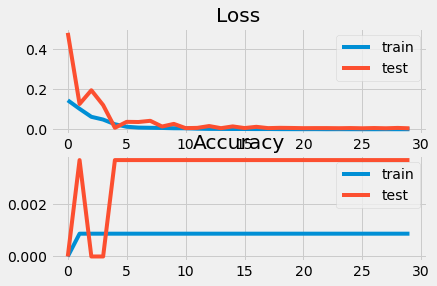

In [140]:
#Train the model
feature_train = np.reshape(feature_train, (feature_train.shape[0], feature_train.shape[1], feature_train.shape[2],1))

feature_test = np.reshape(feature_test, (feature_test.shape[0], feature_test.shape[1], feature_test.shape[2],1))
# label_test = np.reshape(label_test, (label_test.shape[0], label_test.shape[1], label_test.shape[2]))

history = model.fit(feature_train, label_train, batch_size=512, epochs=30,validation_data = (feature_test, label_test))

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [12]:
_, train_acc = model.evaluate(feature_train, label_train, verbose=0)
_, test_acc = model.evaluate(feature_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

Train: 0.642, Test: 0.550
Saved model to disk


[[0.85501066]
 [0.85607676]
 [0.85714286]
 [0.86460554]
 [0.87206823]
 [0.86140725]
 [0.86247335]
 [0.85607676]
 [0.85820896]
 [0.86140725]
 [0.85074627]
 [0.85714286]
 [0.8880597 ]
 [0.87739872]
 [0.87526652]
 [0.86993603]
 [0.88166311]
 [0.88166311]
 [0.87526652]
 [0.87846482]
 [0.86993603]
 [0.87420043]
 [0.87420043]
 [0.90405117]
 [0.95842217]
 [0.92537313]
 [0.93816631]
 [0.93816631]
 [0.9424307 ]
 [0.945629  ]
 [0.9434968 ]
 [0.9445629 ]
 [0.96801706]
 [0.95415778]
 [0.95522388]
 [0.9424307 ]
 [0.95522388]
 [0.95202559]
 [0.95628998]
 [0.98294243]
 [0.97547974]
 [0.97867804]
 [0.98400853]
 [0.97547974]
 [0.97441365]
 [0.97654584]
 [0.97654584]
 [0.97014925]
 [0.97654584]
 [0.96588486]
 [0.96481876]
 [0.95522388]
 [0.89978678]
 [0.891258  ]
 [0.92537313]
 [0.95309168]
 [0.95522388]
 [0.95948827]
 [0.96481876]
 [0.96375267]
 [0.96801706]
 [0.96588486]
 [0.9424307 ]
 [0.95095949]
 [0.945629  ]
 [0.945629  ]
 [0.92430704]
 [0.92857143]
 [0.90938166]
 [0.91044776]
 [0.8869936 ]
 [0.85

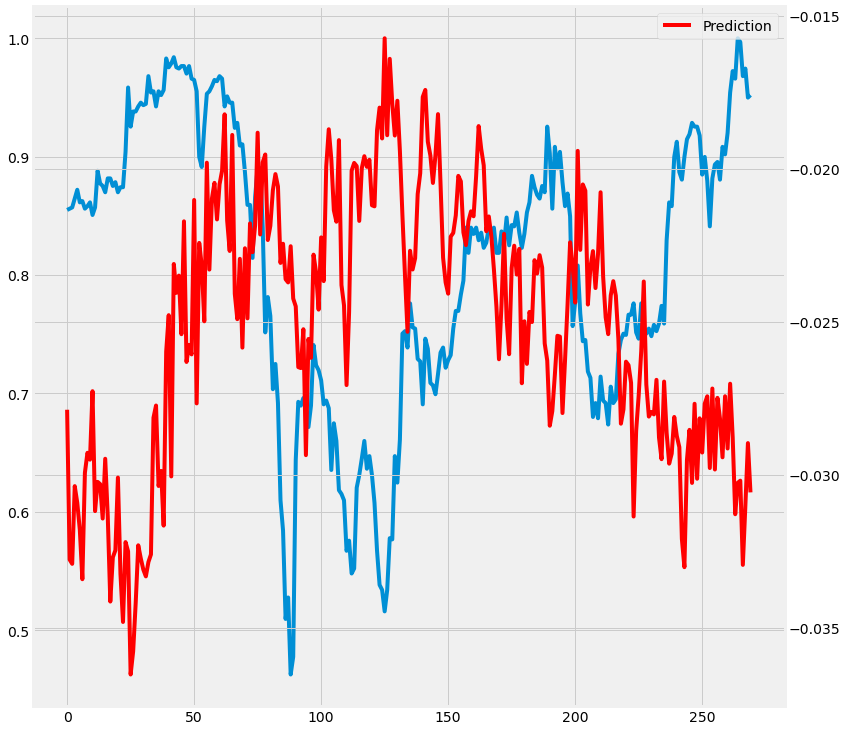

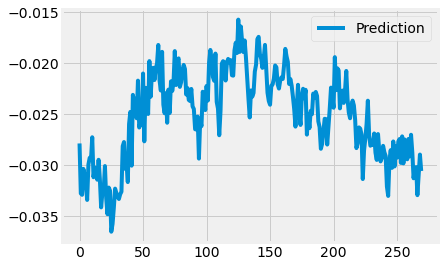

In [138]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_test)
# print(feature_test[-1::])
print(label_test)
print(label_test.shape)
# predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
# print(feature_test)
print(predicted_stock_price)
# print(predicted_stock_price)
print(np.mean(predicted_stock_price))
price=[]
for i in predicted_stock_price:
    if i[0]>=0.5:
        price.append(1)
    else:
        price.append(0)
price = np.array(price)
print(price)
print(price.shape)
plot_results(predicted_stock_price, label_test)
plot_result(predicted_stock_price)

In [ ]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 60)
plot_results_multiple(predictions, label_test, 100)  